# LOB 

Here I design, simulate and analyze a limit order book similar to those used in real financial markets, with a focus on microstructure dynamics, order-flow modelling, and strategy backtesting.

### Overview 
1) LOB Structure
    - Orders: market, limit, cancel
    - Book: price-time priority, bid-ask spread, mid-price
    - Order matching and execution 
2) Order-flow simulation 
    - Synthetic order arrivals (Poisson model)
    - Define distributions for order size, arrival intensity. 
3) Analysis of statistical properties 
    - Spread, volatility, mid-price variance.
    - Market impact and slippage
    - Flow Autocorrelation 
4) Basic Strategy implementation 
    - Market maker arbitrage strategy 
    - Backtest strategy: average returns, sharpe ratio, capital allocation.
  
## 1 — LOB structure 

Our order book will be L3 Market by Order. This means we will keep track of every order: it's price, status, priority, and side. The most important implementation decision is how we will store the orders such that the most common tasks — viewing and removing/matching the best bids and asks is — efficient.

**Price-Time priority** will be used to execute trades. The data structure that best encodes this is a heap of queues: queues manage time-priority while the heap manages price priority. Cancellations pose a problem because they require ID lookup which can be slow, O(N), in heaps. In order to improve this we use a dictionary to map prices to queues which allow for O(1) price lookup and then linear search along a queue assumed to be small. 

In [52]:
from collections import deque
import heapq as hq

class Order: 
    _id_counter = 0 

    def __init__(self, price, volume, is_bid):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        # self.status = "active" # not needed for non-lazy order-cancellation.
        self.id = Order._id_counter
        # Increment class variable to ensure Unique ID.
        Order._id_counter += 1

class PriceLevel:
    def __init__(self, price):
        self.price = price 
        self.orders = deque()
    
    def add(self, order):
        self.orders.append(order)

    def top(self):
        if not self.orders:
            return None
        return self.orders[0] # O(1)

    def pop(self):
        if not self.orders:
            raise IndexError("Price level is empty.")
        return self.orders.popleft() # O(1)
    
    def fill(self, volume):
        to_fill = volume
        filled = 0

        while not self.is_empty(): 
            top_order = self.top()

            if top_order.volume > to_fill: 
                filled += to_fill
                top_order.volume -= to_fill
                to_fill = 0 
                break

            elif top_order.volume == to_fill: 
                filled += to_fill 
                self.pop()
                to_fill = 0 
                break

            else: 
                filled += top_order.volume
                to_fill -= top_order.volume
                self.pop()

        return filled
        

    def cancel(self, order):
        try:
            self.orders.remove(order) # O(n)
        except ValueError:
            raise ValueError("Order not found at this price level.")
        
    def is_empty(self):
        return True if len(self.orders) == 0 else False

class PriceBook:
    def __init__(self, is_bid_side):
        self._price_levels = {}
        self._heap = []
        self.is_bid_side = is_bid_side

    def add(self, order): 
        price = order.price

        if price not in self._price_levels:
            self._price_levels[price] = PriceLevel(price)
            # Use negative price for max-heap behavior on bid side.
            heap_price = -price if self.is_bid_side else price
            hq.heappush(self._heap, heap_price)

        self._price_levels[price].add(order)
    
    def cancel(self, order):
        price = order.price
        if price not in self._price_levels:
            raise ValueError(f"Price {price} not found in PriceBook.")

        try:
            self._price_levels[price].cancel(order)
            # Trying to remove the price level from the heap here would be O(N)
        except ValueError as e:
            # Propagate the original error — don't swallow it
            raise ValueError(f"Failed to cancel order {order.id}: {e}") from e

    def best_price(self):
        if not self._price_levels: 
            return None
        else:
            # Since I didn't remove empty price levels upon order cancellation I have to handle it here
            while self._heap:
                best_price = - self._heap[0] if self.is_bid_side else self._heap[0]
                # Remove empty price levels
                if self._price_levels[best_price].is_empty():
                    hq.heappop(self._heap)
                    del self._price_levels[best_price]
                else: 
                    break

            if self._heap:
                return best_price
            else:
                return None
            
    def peek_best_order(self):
        best_price = self.best_price()
        if best_price:
            return self._price_levels[best_price].top()
        else:
            return None
        
    def fill_volume(self, volume, price): 
        to_fill = volume
        filled = {}
        best_price = self.best_price()

        while best_price and to_fill > 0:
            
            # Check whether prices are compatible
            can_fill = (best_price >= price) if self.is_bid_side else (best_price <= price)

            if can_fill:
                filled_at_price = self._price_levels[best_price].fill(to_fill)
                to_fill -= filled_at_price
                filled[best_price] = filled_at_price
            else:
                break
            
            # This simultaneously removes empty price levels and establishes next best_price
            best_price = self.best_price()

        # Return a dictionary price -> volume filled at price
        return filled
        
class OrderBook:
    def __init__(self, intrinsic_value=100):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.order_map = dict()
        self.intrinsic_value = intrinsic_value
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    # We round calculated spread and mid_price to account for cents being the smallest denomination and floating point errors.
    @property 
    def spread(self):
        if not (self.best_bid and self.best_ask):
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if not (self.best_bid and self.best_ask):
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_order(self, order):

        # Order Matching Logic:
        if order.is_bid: 
            filled = self.asks.fill_volume(order.volume, order.price)
        else:
            filled = self.bids.fill_volume(order.volume, order.price)
        
        filled_volume = sum(filled.values())

        if filled_volume < order.volume:
            order.volume -= filled_volume
            self.order_map[order.id] = order

            if order.is_bid:
                self.bids.add(order)
            else:
                self.asks.add(order)
        
        # We return dictionary of price -> volume filled at price
        return filled

    def cancel(self, order_id):
        try: 
            order = self.order_map[order_id]
        except KeyError as e: 
            raise KeyError(f"Order with id {order_id} could not be found: {e}")

        if order.is_bid:
            self.bids.cancel(order)
        else:
            self.asks.cancel(order)

        del self.order_map[order_id]


**Cursory Testing:** A brief check that the LOB functions as required with non-trivial order processing.

In [53]:
if __name__ == "__main__":
    print("--- Smoke Test for LOB ---")
    # Reset Order Ids 
    Order._id_counter = 0

    # Build OB
    ob = OrderBook()
    # Bids
    ob.process_order(Order(98, 100, is_bid=True))
    ob.process_order(Order(99, 100, is_bid=True))
    ob.process_order(Order(99, 150, is_bid=True))
    # Asks 
    ob.process_order(Order(100, 150, is_bid=False))
    ob.process_order(Order(101, 100, is_bid=False))

    # Test price-time priority with an aggressive ask
    ob.process_order(Order(98, 100, is_bid=False))
    assert ob.best_bid == 99
    assert ob.best_ask == 100 
    assert ob.bids.peek_best_order().id == 2
    print("Price-time priority test passed.")

    # Test partial fills with an aggressive bid
    ob.process_order(Order(101, 50, is_bid=True))
    assert ob.best_bid == 99
    assert ob.best_ask == 100
    assert ob.asks.peek_best_order().volume == 100
    print("Partial fill logic test passed.")

    # Test cancellation
    id = ob.asks.peek_best_order().id
    ob.cancel(id)
    assert ob.best_ask == 101
    print("Cancellation test passed.")

    # Test order processing return values with a large agressive ask
    trades = ob.process_order(Order(70, 200, is_bid=False))
    assert trades[99] == 150
    assert trades[98] == 50 
    assert ob.best_bid == 98
    print("Process Order return test passed.")
    

--- Smoke Test for LOB ---
Price-time priority test passed.
Partial fill logic test passed.
Cancellation test passed.
Process Order return test passed.


### 2 - Simulating Order Flow

In order to backtest trading strategies with slippage I need to have a reasonable model for order-flow.

**Model**
- Order arrival times follow a poisson process with intensity parameter $\lambda$
- Order side is $Bernoulli(p)$. To start we set $p=1/2$ since we will be acting as a market-neutral player.
- Orders will be normally distributed with mean $\mu \pm \gamma$ where $\mu$ is some base price and $\gamma$ is a uniformly distributed offset (- for bids + for asks).

In [210]:
import random as rd
import numpy as np

class OrderFlow: 
    rng = np.random.default_rng(seed=42)

    def __init__(self, arrival_rate=100.0, max_offset=1.0, is_bid_prob=0.5, base_price=100, sigma=0.5, min_volume=10, max_volume=100):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset
        self.is_bid_prob = is_bid_prob
        self.base_price = base_price
        self.sigma = sigma
        self.min_volume = min_volume
        self.max_volume = max_volume
        
    def generate_orders(self): 
        n_orders = OrderFlow.rng.poisson(self.arrival_rate)
        orders = []
        
        for _ in range(n_orders):
            
            # Normally distributed price
            normal = OrderFlow.rng.normal(0, self.sigma)
            offset = OrderFlow.rng.uniform(0, self.max_offset)
            is_bid = OrderFlow.rng.random() < self.is_bid_prob

            if is_bid:
                price = self.base_price + normal - offset
            else: 
                price = self.base_price + normal + offset
            
            # We round to the cent/penny as per most exchanges
            price = round(price, 2) 
            
            # Random order volume
            volume = OrderFlow.rng.integers(self.min_volume, self.max_volume + 1)
            orders.append(Order(price, volume, is_bid))
        
        return orders

**Sanity Check** A brief check that order generation works and that the LOB handles the auto-generated orders reasonably.

In [55]:
flow = OrderFlow()
ob = OrderBook()
timesteps = 10
OrderFlow.rng = np.random.default_rng(seed=42) # Reset rng for reproducibility


for t in range(timesteps):
    orders = flow.generate_orders()
    volume_traded = 0
    trade_prices = set()

    for order in orders:
        trade = ob.process_order(order)
        volume_traded += sum(trade.values())

        # We bucket trading prices into 10 cent increments for better legibility
        for key in trade.keys():
            trade_prices.add(round(key,1))
    
    print(f"""At timestep {t},
          Spread: {ob.spread},
          Mid Price: {ob.mid_price},
          Volume traded: {volume_traded},
          Prices traded at: {trade_prices}""") 
    

At timestep 0,
          Spread: 0.05,
          Mid Price: 100.09,
          Volume traded: 927,
          Prices traded at: {99.9, 100.2, 100.3, 100.1, 100.0, 99.7, 99.6, 99.8}
At timestep 1,
          Spread: 0.09,
          Mid Price: 99.86,
          Volume traded: 1194,
          Prices traded at: {99.9, 100.2, 100.1, 99.8, 99.6, 99.5, 100.0, 99.7}
At timestep 2,
          Spread: 0.11,
          Mid Price: 99.78,
          Volume traded: 588,
          Prices traded at: {99.9, 99.8, 100.0, 99.7}
At timestep 3,
          Spread: 0.07,
          Mid Price: 100.0,
          Volume traded: 556,
          Prices traded at: {99.8, 100.0, 99.7, 99.9}
At timestep 4,
          Spread: 0.05,
          Mid Price: 99.94,
          Volume traded: 633,
          Prices traded at: {99.9, 100.1, 99.7, 100.0, 99.8}
At timestep 5,
          Spread: 0.11,
          Mid Price: 99.84,
          Volume traded: 715,
          Prices traded at: {99.8, 99.9, 100.0, 99.7}
At timestep 6,
          Spread:

## 3 - Market Making Strategy 

Now that we have a working order book and order flow generator we can try and test a strategy. For this toy model, it only makes sense to test market neutral strategies since the price has no drift. We will implement a simple market making strategy trying to capture the spread. 

We will track orders at the strategy level rather than introducing trading histories at the Order Book Level. This is sufficient for our purposes. 

In [56]:
class SimpleMarketMaker():
    def __init__(self, inventory_limit=1000, quote_size=100):
        self.inventory = 0
        self.cash = 0
        self.active_orders = {}

        self.inventory_limit = inventory_limit
        self.quote_size = quote_size
    
    def update(self, order_book):
        # First we check whether orders on the previous times tep were filled 
        for order_id, (price, volume, is_bid) in list(self.active_orders.items()):
            
            # Check for full fills 
            if order_id not in order_book.order_map:
                self._record_fill(price, volume, is_bid)
                del self.active_orders[order_id]

            # Check for partial fills  
            else: 
                remaining_volume = order_book.order_map[order_id].volume

                if remaining_volume == 0:
                    raise ValueError("A filled order remained on the books.")
                
                elif remaining_volume > volume:
                    raise ValueError("Order book's volume exceeds our count.")
                
                else: 
                    filled_volume = volume - remaining_volume 
                    self._record_fill(price, filled_volume, is_bid)
                    self.active_orders[order_id] = (price, remaining_volume, is_bid)
                
        # Generate an order via a strategy 
        orders = self.strategy(order_book)

        # Post Quote
        for order in orders:
            order_book.process_order(order)
            self.active_orders[order.id] = (order.price, order.volume, order.is_bid)
    
    def _record_fill(self, price, volume, is_bid):
        if is_bid: 
            self.cash -= price * volume 
            self.inventory += volume
        else:
            self.cash += price * volume 
            self.inventory -= volume 
    
    def strategy(self, order_book):
        orders = []
        tick = 0.01
        if order_book.best_ask == None or order_book.best_bid == None:
            ask = order_book.intrinsic_value + tick
            bid = order_book.intrinsic_value - tick
        else:
            ask = round(order_book.best_ask - tick, 2)
            bid = round(order_book.best_bid + tick, 2)

        # Basic Strategy: if too long we stop quoting bids, if too short we stop quoting asks.
        # If we have unfilled orders on the book replace them with new quotes
        for order_id in list(self.active_orders.keys()):
            try:
                order_book.cancel(order_id)
                del self.active_orders[order_id]
            except:
                # Order may already be filled (this exception shouldn't ever trigger.)
                pass

        if self.inventory < self.inventory_limit:
            orders.append(Order(bid, self.quote_size, True))

        if self.inventory > -self.inventory_limit:
            # calculate how many bids I can afford:
            orders.append(Order(ask, self.quote_size, False))

        return orders
    
    def pnl(self, order_book):
        if order_book.mid_price: 
            unrealised_pnl = self.inventory * order_book.mid_price
        else:
            unrealised_pnl = 0 
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

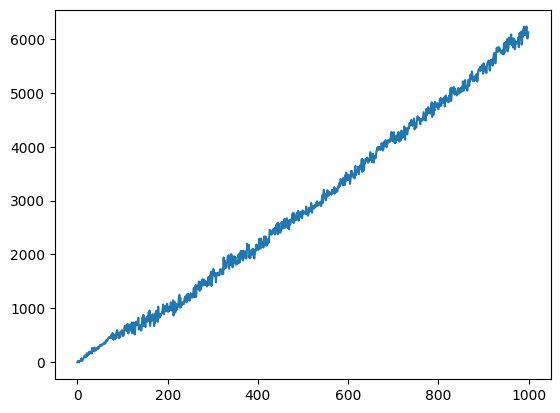

In [57]:
import matplotlib.pyplot as plt
mm = SimpleMarketMaker()
of = OrderFlow()
ob = OrderBook()

def simulate(order_book, order_flow, market_maker, timesteps):
    pnl = np.zeros(timesteps)
    for t in range(timesteps):
        # Simulate order flow 
        orders = order_flow.generate_orders()
        for order in orders:
            order_book.process_order(order)
        
        # Market Maker updates quotes
        market_maker.update(order_book)

        # Market Maker updates pnl
        pnl[t] = market_maker.pnl(order_book)
    
    return pnl

pnl = simulate(ob, of, mm, 1000)
plt.plot(pnl)

        

    

## 4 — Realism Upgrade 

At the moment, our rudimentary market making strategy prints money — we have a risk free spread capture. There are a number of reasons for this:

### 1. Order flow is pegged to a static price

In the current setup the base-price is fixed. As a result, the market maker faces almost no inventory risk — holding a long or short position carries no cost.

**In real markets**: Price evolves with executed trades. Future prices are determined by order imbalances in aggressive flow generated by market takers. Balancing spread capture with inventory risk is the primary risk-reward tradeoff navigated by market makers.

**Fix:** Introduce dynamic asset pricing via signed order flow impact.

### 2. Completely random order flow

The existing order flow is generated i.i.d around a fixed base price which suggests orders arrivals are uncorrelated and informationless. This implies the market maker has perfect information about the security price. 

**In real markets**: Liquidity takers are often informed.
- Acting upon indicators or external information, aggressive trades precede price moves in their favour.
- This exhibits as autocorrelation and directional bias in order flow.
- The cost of being the uninformed agent is **Adverse selection** — it is an important real-world risk for market makers.

**Fix:** Introduce flow autocorrelation that simulates informed aggression.

### 3. Zero Latency Trading

Currently, the market maker can: 
- Observe the state of the order book.
- Instantly cancel quotes.
- Post new ones inside the spread.
- Automatically take queue priority. 

**In real markets**: All players are face computation and communication latency. Market makers can't view the book and instantly update their quotes — the market may move or their quotes hit while reacting.

**Fix:** Introduce quoting latency.

To start, I will address the first two points by simulating aggressive flow. We will need to: ammend the Order class to differentiate between market orders and limit orders; adjust the OrderFlow Class to generate autocorrelative aggressive flow; Adjust OrderBook Class to correctly fill market orders; Adjust simulation function to correct the base price as a function of traded volume.

In [211]:
class Order: 
    _id_counter = 0 

    def __init__(self, price=None, volume=100, is_bid=True, is_market=False):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        self.id = Order._id_counter
        Order._id_counter += 1

        #is_market flag for a market order
        self.is_market = is_market

class OrderFlow: 
    rng = np.random.default_rng(seed=42)

    def __init__(self, arrival_rate=100, max_offset=0.05, sigma=0.02, min_volume=10, max_volume=100, market_frac=0.1, imb_coeff=0.7, ar_decay=0.7):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset

        # Remove is_bid_prob since uninformed flow should be neutral
        # self.is_bid_prob = is_bid_prob

        # Base price is determined by order book mid price
        # self.base_price = base_price
        self.sigma = sigma
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Introduce aggressive traders
        self.market_frac = market_frac

        # Impact of trade momentum on bid probability of informed traders
        self.imb_coeff = imb_coeff
        # Informed traders will decide whether to bid based on an autoregressive volume signal
        self.ar_imb = 0
        self.ar_decay = ar_decay
    
    def update_signal(self, order_book):
        if order_book.buy_volume + order_book.sell_volume == 0:
            imbalance = 0
        else:
            imbalance = (order_book.buy_volume - order_book.sell_volume)/(order_book.buy_volume + order_book.sell_volume)
        
        # Standard AR(1): mean-reverting momentum signal
        self.ar_imb = self.ar_decay * self.ar_imb + (1 - self.ar_decay) * self.imb_coeff * imbalance
        
    def generate_orders(self, order_book): 
        n_orders = OrderFlow.rng.poisson(self.arrival_rate)
        orders = []

        # mid_price replaces base_price.
        if order_book.mid_price is None:
            # Fallback for when book is empty (intrinsic value of security)
            mid_price = order_book.intrinsic_value
        else:
            mid_price = order_book.mid_price
        
        for _ in range(n_orders):

            # Simulate aggressive flow
            is_market = OrderFlow.rng.random() < self.market_frac
            
            # If the bid is part of aggressive flow skew bid frac
            if is_market:
                # Bid probability scales with the the signal
                bid_prob = 0.5 + 0.5 * np.tanh(2 * self.ar_imb)
                is_bid = OrderFlow.rng.random() < bid_prob

                # Price is placed as high (low) as possible so they always cross the spread, even with slippage.
                price = float('inf') if is_bid else -float('inf')

            else: 
                # Neutral bids are generated as before
                is_bid = OrderFlow.rng.random() < 0.5
                normal = OrderFlow.rng.normal(0, self.sigma)
                offset = OrderFlow.rng.uniform(0, self.max_offset)
            
                if is_bid:
                    price = mid_price + normal - offset
                else: 
                    price = mid_price + normal + offset
    
                price = round(price, 2) 
                
            volume = OrderFlow.rng.integers(self.min_volume, self.max_volume + 1)
            orders.append(Order(price, volume, is_bid, is_market))
        
        return orders

In [212]:
class OrderBook:
    def __init__(self, intrinsic_value=100):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.order_map = dict()
        self.intrinsic_value = intrinsic_value

        # Volume traded in a timestep 
        self.buy_volume = 0
        self.sell_volume = 0
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    @property 
    def spread(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_order(self, order):

        if order.is_bid: 
            filled = self.asks.fill_volume(order.volume, order.price)
        else:
            filled = self.bids.fill_volume(order.volume, order.price)
        
        filled_volume = sum(filled.values())

        # Only add remaining volume to book if it is a limit order
        if filled_volume < order.volume and not order.is_market:
            order.volume -= filled_volume
            self.order_map[order.id] = order

            if order.is_bid:
                self.bids.add(order)
            else:
                self.asks.add(order)
    
        # Update aggresive volumes traded this timestep 
        if order.is_bid:
            self.buy_volume += filled_volume
        else:
            self.sell_volume += filled_volume 
        
        return filled
    
    # A helper function to reset the trading volumes at each timestep
    def reset_volumes(self):
        self.buy_volume = 0 
        self.sell_volume = 0

    def cancel(self, order_id):
        try: 
            order = self.order_map[order_id]
        except KeyError as e: 
            raise KeyError(f"Order with id {order_id} could not be found: {e}")

        if order.is_bid:
            self.bids.cancel(order)
        else:
            self.asks.cancel(order)

        del self.order_map[order_id]

[ 99.94  99.96  99.96  99.96  99.96  99.98  99.98 100.   100.03 100.03
 100.03 100.03 100.03 100.03 100.03 100.03 100.03 100.03 100.   100.
 100.   100.    99.98  99.98  99.98  99.97  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.97  99.94  99.94  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.95  99.98  99.98  99.98  99.98  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97  99.97
  99.97 

/var/folders/c_/m3x98zjs2bb6cm1g0y7c6v2w0000gn/T/ipykernel_97168/3645097041.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


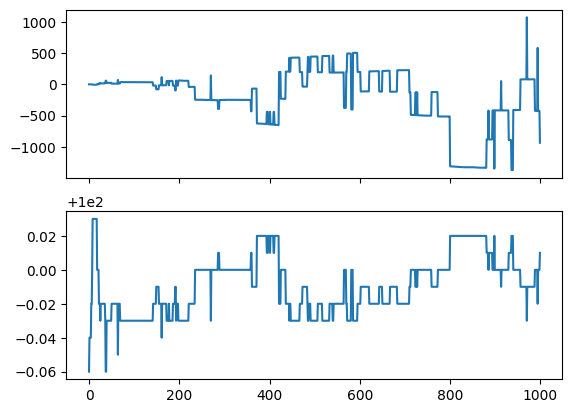

In [209]:
import matplotlib.pyplot as plt
mm = SimpleMarketMaker(quote_size=100, inventory_limit=100000)
of = OrderFlow(market_frac=0, imb_coeff=0.0, ar_decay=0.0)
ob = OrderBook()


def simulate(order_book, order_flow, market_maker, timesteps):
    pnl = np.zeros(timesteps)
    mp = np.zeros(timesteps)

    for t in range(timesteps):

        # Simulate order flow for timestep t
        orders = order_flow.generate_orders(ob)
        for order in orders:
            order_book.process_order(order)
        # Update signal for order flow
        order_flow.update_signal(ob)
        
        # Market Maker updates quotes for timestep [t, t+1]
        market_maker.update(order_book)

        # Market Maker updates pnl
        pnl[t] = market_maker.pnl(order_book)
        mp[t] = ob.mid_price

        ob.reset_volumes()

    return pnl, mp

pnl, mp = simulate(ob, of, mm, 1000)
print(mp)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(pnl)
ax2.plot(mp)
fig.show()
